## Introduction
The goal of EDA stage is to check data & examine it. We want to see how targets correlate with the text, find words that demonstrate the difference between toxicity classes.

Columns:
* ID: comment ID.
* target: toxicity level based on some previous algorithm or human-based ranking (float).
* comment_text: comment.
* severe_toxicity:  subtarget, float, shows severe toxicity level from 0 to 1.
* obscene:  subtarget, float shows obscene level from 0 to 1.
* identity_attack: subtarget, float, shows identity attack level from 0 to 1.
* insult: subtarget, float, shows insult level from 0 to 1.
* threat: subtarget, float, shows threat level from 0 to 1.

### Contents:
* Preparing the ground
    * Importing Libs and Datasets
    * Data check and preprocessing
* Visualization
    * Toxicity type proportion
    * Tag strength proportion
    * Target distribution
    * Multi-tagging
    * Correlation matrix
    * Corpus cleaning
    * TF-IDF Unigrams
    * Example Comments
    * Wordclouds: most common words
* Conclusion

### Importing Libs and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import string
import re
# import warnings
# warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import langdetect 
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_csv("D:/Programming/DB's/Toxic_database/tox_train.csv")
# df2 =pd.read_csv("D:/Programming/DB's/Toxic_database/tox_test.csv")
#10 sec loading

### Data check and preprocessing

In [14]:
df.tail(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat
1804869,6333967,0.000000,"Maybe the tax on ""things"" would be collected w...",0.000000,0.000000,0.000000,0.000000,0.0
1804870,6333969,0.000000,What do you call people who STILL think the di...,0.000000,0.000000,0.000000,0.000000,0.0
1804871,6333982,0.000000,"thank you ,,,right or wrong,,, i am following ...",0.000000,0.000000,0.000000,0.000000,0.0
1804872,6334009,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0
1804873,6334010,0.000000,Students defined as EBD are legally just as di...,0.000000,0.000000,0.000000,0.000000,0.0


* Train df has 8 columns and ≈ 1,805,000 rows 

In [5]:
df.drop_duplicates(subset=['id']).tail(1)# we drop all ID duplicates and nothing is dropped (still 1804873 comments)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat
1804873,6334010,0.0,Students defined as EBD are legally just as di...,0.0,0.0,0.0,0.0,0.0


* ID: is not an account ID, just a  comment number.

In [136]:
df2.tail()

,id,comment_text
97315,7194635,He should lose his job for promoting mis-infor...
97316,7194636,"""Thinning project is meant to lower fire dange..."
97317,7194637,I hope you millennials are happy that you put ...
97318,7194638,I'm thinking Kellyanne Conway (a.k.a. The Trum...
97319,7194639,I still can't figure why a pizza in AK cost mo...


* Test dataset has only ID and comment columns, so we can't train on it, no cheating. It has about 97000 rows.

In [19]:
#run only if you uncomment df2 (test df)
print(f' ≈ {round(df2.shape[0]/((df.shape[0]+df2.shape[0])/100),2)} % ')

 ≈ 5.12 % 


* The size of the test dataset is ≈ 5% of all data.

In [28]:
print(df.isnull().sum())

id                 0
target             0
comment_text       0
severe_toxicity    0
obscene            0
identity_attack    0
insult             0
threat             0
dtype: int64


* There are no null values 

In [3]:
df_withDup=df#first_Original
df=df.drop_duplicates(keep=False,subset=['comment_text'])#no dup
df_dupOnly=df_withDup.loc[~df_withDup.comment_text.isin(df.comment_text)]#only dup

* Creating three separate datasets: with duplicates, without duplicates, and only with duplicates
* Duplicates are removed in df variable

In [17]:
print(df_dupOnly.sort_values('comment_text')[['target','comment_text']])

           target                                       comment_text
35276    0.800000  " Just another reminder that people are genera...
35274    0.862069  " Just another reminder that people are genera...
35275    0.795918  " Just another reminder that people are genera...
1800939  0.400000  " Mr. Drumpf's speech before the Asian Pacific...
1800998  0.400000  " Mr. Drumpf's speech before the Asian Pacific...
...           ...                                                ...
1773121  0.000000  💙   ScreenViewsHD   💙  is the best to watch nf...
1773134  0.000000  💙   ScreenViewsHD   💙  is the best to watch nf...
518735   0.000000                                                  🙄
430730   0.000000                                                  🙄
834734   0.000000                                                  🙄

[34231 rows x 2 columns]


* Dropping all duplicates for now to analyze them later. 

Some of them have different targets and that's disturbing. Hence, we can't leave even 1 duplicate, because the target can
vary from 0.1 to 0.9 (unchecked yet). Get .mean of a target wouldn't work and'll break future model. There are two ways:
We can analyze each comment and try to chose correct target ranges, or just leave it for now.

In [5]:
a=df_withDup.shape[0]
b=df.shape[0]
c=df_dupOnly.shape[0]
print('Total number of comments:',a)
print(f'Number of unique comments: {str(round((b/(a/100)),2))} % or {b}')
print('Number of duplicated comments:',str(round((c/(a/100)),2))+' %','or',c)

Total number of comments: 1804874
Number of unique comments: 98.1 % or 1770643
Number of duplicated comments: 1.9 % or 34231


Duplicates and unique comments ratio:
   * Total number of comments: 1804874
   * Number of unique comments: 98.1 % or 1770643
   * Number of duplicated comments: 1.9 % or 34231

In [4]:
print(df.comment_text.tail(1))
df=df.reset_index(drop=True)
print(df.comment_text.tail(1))

1804873    Students defined as EBD are legally just as di...
Name: comment_text, dtype: object
1770642    Students defined as EBD are legally just as di...
Name: comment_text, dtype: object


* Dropping empty ID's by resetting indexation. Now the last ID is the same as the number of comments.

In [5]:
df['target_class']=(df['target']>=0.5).map(int)#if more than .5 - than toxic.

* Creating Rough toxic classification based on 0.5 target threshold to count clean and toxic comments (class imbalance).

In [20]:
print(f"Total comments: {len(df['target_class'])}")
df['target_class'].value_counts(normalize=True) \
.mul(100) \
.round() \
.rename(index={0:'Total clean comments:',1:'Total toxic comments:'}) \
.astype(str)+'%'  

Total comments: 1770643


Total clean comments:    92.0%
Total toxic comments:     8.0%
Name: target_class, dtype: object

Clean & toxic comments ratio depending on target_class threshold of 0.5 is:
   * Total comments: 1770643
   * Total clean comments: 92.0 %
   * Total toxic comments: 8.0 %

In [353]:
target_category = ['severe_toxicity','obscene','identity_attack','insult','threat']
df_temp=df.loc[:, target_category]
df_temp['most_toxicity']=df_temp.loc[:, target_category][df_temp.loc[:, target_category] > 0.0] \
.dropna(axis=0,how='all') \
.idxmax(axis=1, skipna=True)
df_temp=df_temp.fillna('Clean')

* Creating df_temp
* Creating the 'most_toxicity' column where we classify comments that are toxic, using row maximal value, skipping clean comments.

In [14]:
df_temp['least_toxicity']=df_temp.loc[:,target_category]\
[((df_temp.loc[:,target_category].sum(axis=1))>0)] \
.replace(0, np.nan).idxmin(axis=1, skipna=True)
df_temp=df_temp.fillna(0)

* Creating least_toxicity feature, it names least toxic subtarget. 
* I assume that we filter all what's left in between and put it to features like 'less_toxic' 'mild_toxic' etc.

In [407]:
df_temp.head(15)

,severe_toxicity,obscene,identity_attack,insult,threat,most_toxicity
0,0.000000,0.000000,0.000000,0.000000,0.0,Clean
1,0.000000,0.000000,0.000000,0.000000,0.0,Clean
2,0.000000,0.000000,0.000000,0.000000,0.0,Clean
3,0.000000,0.000000,0.000000,0.000000,0.0,Clean
4,0.021277,0.000000,0.021277,0.872340,0.0,insult
5,0.047619,0.638095,0.000000,0.333333,0.0,obscene
6,0.050847,0.305085,0.000000,0.254237,0.0,obscene
7,0.000000,0.000000,0.000000,0.000000,0.0,Clean
8,0.000000,0.000000,0.000000,0.000000,0.0,Clean
9,0.000000,0.000000,0.000000,0.000000,0.0,Clean


* how to remove duplicate in 15th row?

In [273]:
df_temp[(df_temp['most_toxicity'] == df_temp['least_toxicity']) & ((df_temp.loc[:,target_category].sum(axis=1))>0)] \
['least_toxicity'].apply(lambda x: x.replace(x,'hehe')).head(20)#df_temp['least_toxicity']=

* Trying to remove duplicates

### Visualization

In [489]:
x=df_temp.loc[:,'most_toxicity'][df_temp.loc[:,'most_toxicity']!=0].value_counts()[[5,3,2,1,4]]#[[4,2,1,0,3]]
prc=(x/(x.sum())*100).round(1).astype(float).astype(str)+'%'
fig = px.bar(x, x=x.index, y=x.values, height=500,color=x.index, text=prc, title='Toxicity type proportion',\
labels={"y": "# of toxic comments","index":"Toxic type","text":"Part"})
fig.update_layout(showlegend=True)
fig.show()

* Based on most_toxicity feature there are overbalance of insult class. 

In [8]:
print(f'# of all comments: {df_temp.shape[0]}')
print('# of toxic comments: ',df_temp.loc[:,'most_toxicity'][df_temp.loc[:,'most_toxicity']!=0].shape[0],'or',\
      round((df_temp.loc[:,'most_toxicity'][df_temp.loc[:,'most_toxicity']!=0].shape[0]\
             /(df_temp.shape[0]/100)),2),'%')

# of all comments: 1770643
# of toxic comments:  526808 or 29.75 %


Clean & toxic comments ratio based on most_toxicity feature (preliminary):
* number of all comments: 1770643
* number of toxic comments:  526808 or 29.75 %
* Almost 30 % are toxic, it's much more than 8% based on 0.5 threshold

---
* To check, is it a lot of strong values or we should always work with subtle and weak ones lets build "Tag strength proportion" barplot

In [488]:
df_oneline=df_temp['severe_toxicity'].append(df_temp['obscene']).append(df_temp['identity_attack']) \
.append(df_temp['insult']).append(df_temp['threat'])
df_oneline=df_oneline[df_oneline!=0]#removing 0s
oneline=pd.qcut(df_oneline,10,duplicates='drop')
x=oneline.value_counts(sort=0)
prc=(x[1:]/(x[1:].sum())*100).round(1).astype(str)+'%'
fig = px.bar(x=x.index[1:].astype('str'),y=x.values[1:],color='From/To '+x.index[1:].astype('str'), height=500, text=prc,\
             title='Tag strength proportion',labels={"y": "# of tags","x":"Toxic range","text":"Part","color":"Toxic bar range:"})
fig.update_layout(showlegend=True)
fig.show()

* We can clearly define the toxic type in 10% of cases, and rest of them can be enchanced with weights.

In [26]:
print('# of comments with weak subtargets sum: ',
      df_temp[(df_temp.sum(axis=1,numeric_only=True)<=.09)&(df_temp.sum(axis=1,numeric_only=True)!=0)].shape[0]) 
print('# of comments with strong subtargets sum: ',df_temp[df_temp.sum(axis=1,numeric_only=True)>1.01].shape[0])

# of comments with weak subtargets sum:  1203
# of comments with strong subtargets sum:  32871


Quantity of comments with weak and strong subtargets:
* number of comments with weak subtargets (can be enchanced with weights):  1203
* number of comments with strong subtargets (comments with more than 1.01 sum value):  32871
* The weak subtargets aren't many, it is much more strong ones, which are more than 1 in total.

In [491]:
def plot(subtarget_list: list,subtarget_names: str,use_equal: bool):
    """Barplot which groups values of each toxic data type. 
    
    The function creates multiple barplots, shows absolute and relative (in %) quantity of 
    comments and their values. Target series is shown in qcut to understand thresholds of each bar,
    all other subtargets uses cut command (because qcut didn't work well).
    
    Parameters
    ----------
    subtarget_list: change data series
    subtarget_names: change plot title
    use_equal: switch qcut and cut commands
    
    Returns
    -------
    Threshold plots by each column.
    
    """
    if use_equal:
        x=pd.qcut(df['target'],45,duplicates='drop')
    else:
        x=pd.cut(df[subtarget_list],6,duplicates='drop')
    x=x.value_counts(sort=0)
    prc=(x[1:]/(x[1:].sum())*100).round(1).astype(str)+'%'
    fig = px.bar(x=x.index[1:].astype('str'),y=x.values[1:], \
                 text=prc, title=subtarget_names, \
                 labels={"y": "# of comments","x":"Toxic range","text":"Part"})
    fig.show()
subtarget_list=['target','severe_toxicity','obscene','identity_attack','insult','threat']
subtarget_names=['Target distribution','Severe toxicity subtarget distribution','Obscene subtarget distribution',
                 'Identity attack subtarget distribution','Insult subtarget distribution','Threat subtarget distribution']
use_equal=[True,False,False,False,False,False]
for i in range(5):
    plot(subtarget_list[i],subtarget_names[i],use_equal[i])

We created barplots for each toxic data type. 
* Each subtargets shows that there are much more comments with weak toxicity than a strong one.
* severe_toxic barplot shows absence of strong samples.
    

### Multi-tags

In [494]:
#Multi-tagging count plot
x=df_temp.loc[:,target_category][df_temp.loc[:,target_category]>0].count(axis=1).value_counts()[1:]
prc=(x/(x.sum())*100).round(1).astype(float).astype(str)+'%'
fig = px.bar(df_temp,x=x.index.astype('str'),y=x.values, color=x.index.astype('str')+([' tag']+4*[' tags']),height=500, text=prc,\
             title='Multi-tagging',labels={"y": "# of comments with","x":"# of tags","text":"Part","color":"Tags quantity:"})
fig.update_layout(showlegend=True)
fig.show()

Multi-tag barplot shows how many tags comments have.
* Half the time, comment has 1 tag.

### Correlation matrices

In [502]:
corr=df_temp.corr().round(2)#Correlation matrix between subtargets
mask = np.zeros_like(corr, dtype=bool)#Creating mask for upper triange
mask[np.triu_indices_from(mask)] = True 
corr[mask] = np.nan#dropping triangle
fig = px.imshow(corr, text_auto=True,aspect="auto",labels={"color": "Correlation"},title='Correlation matrix')
fig.show()

Correlation matrix shows that:
* The strongest correlation between insult & obscene (0.43).
* The second place is occupied by obscene & severe toxicity (0.34).
* 3rd place - severe toxicity & insult (0.32).

In [500]:
df_s = df[df['target'] > 0 ]
corr=df_s[['target']+ target_category].corr().round(2)
# corr=df_temp.corr().round(2)#Correlation matrix between subtargets
mask = np.zeros_like(corr, dtype=bool)#Creating mask for upper triange
mask[np.triu_indices_from(mask)] = True 
corr[mask] = np.nan#dropping triangle
fig = px.imshow(corr, text_auto=True,aspect="auto",labels={"color": "Correlation"},title='Correlation matrix + target')
fig.show()

Correlation matrix + target:
* Target correlate the most with insult.
    * That means that target pays attention more for any kind of insult comment (0.87)
    * 2nd place is obscene (0.42)
    * 3rd place for identity attack & severe toxicity (0.22 & 0.26)
    * target pay attention less for threat comments (0.13).
* We should determine threat the most.

### Corpus cleaning:

In [549]:
df.loc[1,'comment_text']

'thank you this would make my life a lot less anxiety inducing keep it up and do not let anyone get in your way'

In [535]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)# != a-z, A-Z, and 0-9
    text = re.sub('\s+', ' ', text)# s(spaces)== \t \n \r (return carret on the beginning)
    
    text=re.sub('<.*?>', ' ', text)   
    text = text.translate(str.maketrans(' ',' ',string.punctuation)) 
    text = re.sub('[^a-zA-Z]',' ',text)  
    text = re.sub("\n"," ",text)
    text = text.strip(' ')
    return text

In [547]:
df['comment_text']=df['comment_text'].apply(clean_text)

### Графік stripplot в tf-idf з plotly

In [550]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())
train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])

In [601]:
tfidf=TfidfVectorizer(ngram_range=(1,1),max_df=.8,min_df=10,stop_words = STOPWORDS.union(set(['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn','let',
            'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])))

In [602]:
X=tfidf.fit_transform(df.loc[:,'comment_text'])#4 mins

In [567]:
features = np.array(tfidf.get_feature_names_out())

In [603]:
X.shape

(1770643, 38507)

In [604]:
train_unigrams = X

In [605]:
df.iloc[:,3:8]

,severe_toxicity,obscene,identity_attack,insult,threat
0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.000000,0.000000,0.000000,0.0
4,0.021277,0.000000,0.021277,0.872340,0.0
...,...,...,...,...,...
1770638,0.000000,0.000000,0.000000,0.000000,0.0
1770639,0.000000,0.000000,0.000000,0.000000,0.0
1770640,0.000000,0.000000,0.000000,0.000000,0.0
1770641,0.030303,0.030303,0.045455,0.621212,0.0


In [606]:
#serperate train and test features
# train_feats=df.iloc[0:len(train),]
# test_feats=df.iloc[len(train):,]
#join the tags

train_tags=df.iloc[:,3:8]
# train_feats=pd.concat([train_feats,train_tags],axis=1)

In [607]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

IndexError: index 38506 is out of bounds for axis 0 with size 103

In [592]:
import matplotlib.gridspec as gridspec 

In [653]:
tfidf_top_n_per_lass

[          feature  tfidf
 0            zeus    0.0
 1            jock    0.0
 2   episcopalians    0.0
 3          exiled    0.0
 4           frees    0.0
 5             gif    0.0
 6         hounded    0.0
 7          impart    0.0
 8          infamy    0.0
 9          infirm    0.0
 10       infusion    0.0
 11      instigate    0.0
 12       lacrosse    0.0
 13   electricians    0.0
 14        leopard    0.0
 15         locale    0.0
 16          lucid    0.0
 17           luis    0.0
 18          mauka    0.0
 19     memorandum    0.0,
           feature  tfidf
 0            zeus    0.0
 1            jock    0.0
 2   episcopalians    0.0
 3          exiled    0.0
 4           frees    0.0
 5             gif    0.0
 6         hounded    0.0
 7          impart    0.0
 8          infamy    0.0
 9          infirm    0.0
 10       infusion    0.0
 11      instigate    0.0
 12       lacrosse    0.0
 13   electricians    0.0
 14        leopard    0.0
 15         locale    0.0
 16        

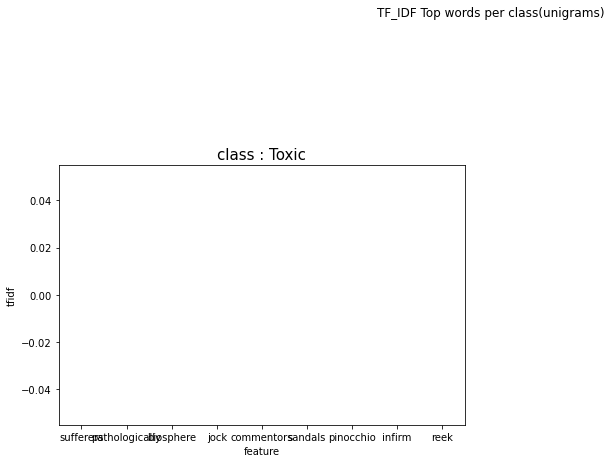

In [657]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)")
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(x=tfidf_top_n_per_lass[3].feature.iloc[0:9],y=tfidf_top_n_per_lass[0].tfidf.iloc[0:9])
plt.title("class : Toxic",fontsize=15)
# plt.xlabel('Word', fontsize=12)
# plt.ylabel('TF-IDF score', fontsize=12)
plt.show()

### Adding indirect features

### train/test/validation треба розбити до того як робити features
* на test/validation бери по 10 чи 15% дати
* train/test розбити по target класу
* fit роблю на train а на validation& test роблю transorm

In [27]:
#Word count in each comment:
df_temp.loc[:,'count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df_temp.loc[:,'count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df_temp.loc[:,'count_letters'] = df["comment_text"].apply(lambda x: len(str(x)))# воно рахує з пробілами... так і треба?
#punctuation count
df_temp.loc[:,"count_punctuations"] = df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))# I'll -всередині це ж не пунктуація?

In [28]:
#upper case words count
df_temp.loc[:,"count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df_temp.loc[:,"count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df_temp.loc[:,"count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
#який список stopwords оптимальний по розміру та швидкості?
#Average length of the words
df_temp.loc[:,"mean_word_len"] = df["comment_text"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()]),2))

In [29]:
#derived features
#Word count percent in each comment:
df_temp.loc[:,'word_unique_percent']=df_temp.loc[:,'count_unique_word']*100/df_temp['count_word']
#Punct percent in each comment:
df_temp.loc[:,'punct_percent']=df_temp.loc[:,'count_punctuations']*100/df_temp['count_word']

In [37]:
# df_temp
df_temp2=df.loc[:,['id','target','comment_text','target_class']]
df_temp=pd.concat([df_temp2, df_temp], axis=1, join='inner')
df_temp

,id,target,comment_text,target_class,severe_toxicity,obscene,identity_attack,insult,threat,most_toxicity,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0,0.0,0.0,0.0,0.0,0.0,0,19,19,101,9,0,2,7,4.37,100.0,47.368421


In [38]:
#spammers - comments with less than 40% unique words
spammers=df_temp[df_temp.loc[:,'word_unique_percent']<40]
print("Clean Spam example:")
print(spammers[spammers.loc[:,'target_class']<.5].comment_text.iloc[0])
print("Toxic Spam example:")
print(spammers[spammers.loc[:,'target_class']>.5].comment_text.iloc[0])

Clean Spam example:
Hardesty: "Are you going to do away with the 48-hour rule?"

Bailey: "Blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, 
blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, 
blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, 
blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, blah, 
blah."
Toxic Spam example:
. . . cuckoo . . . cuckoo . . .


### Language Detection (skip)

In [120]:
# df['id'][0]# стандартний слайс рубить попервах по колонні потім по рядку . Привласнення не рекомендовано, 
# бо воно все простирадло двічі ріже, тому фу-фу бути таким
# df.loc[0,'id']=6# loc & iloc лупаше навпаки, по рядку а потім по колонні
# df.iloc[0,:].sum()


# df.loc[:,'obscene']# все по 0 осі, по 1 осі тільки лейбл.
# df.loc[df['obscene']>.5]#condition обрізає по 0 осі
# df.loc[lambda df: df['obscene']>.5]['obscene']#condition обрізає по 0 осі
# df.loc[df['obscene']>.5,['target_class']]#condition обрізає по 0 осі, вертає вибрану колонку(и)
# df.loc[0]=10
# df[df['A'] > 2]['B']
# df.loc[df['A'] > 2, 'B'] = new_val
# df['id'][0]=5# якщо вибирати slice то першим обрізка йде по колонні а потім вже по рядках
df['lang']=langdetect.detect(comment)
def lang(comment):
    try:
        df['lang']=langdetect.detect(comment)
        return langdetect.detect(comment)
    except:
        pass
for i in df['comment_text'][0:10]:
    print(i+1,lang(i),end='\n\n')

86.0

### Comments example:

Severe_toxicity example:

In [317]:
pd.set_option('display.max_colwidth', None)
print("Severe_toxicity Top 5: ↓↓↓\n",df[df.severe_toxicity>=.55].iloc[:,3:-1].head(5))
print(f"\nHere's severe toxicity example: ↓↓↓\n\n {df[df.severe_toxicity>=1].iloc[:,2]}")

Severe_toxicity Top 5: ↓↓↓
          severe_toxicity   obscene  identity_attack    insult    threat
1316639         0.569070  0.596872         0.917463  0.887055  0.892268
1352166         1.000000  0.000000         0.000000  1.000000  1.000000
1416021         0.600000  0.800000         0.400000  0.800000  0.500000
1504028         0.644363  0.970669         0.076994  0.978002  0.739688
1647146         0.591236  0.972389         0.909964  0.971789  0.819928

Here's severe toxicity example: ↓↓↓

 1352166    Awesome! Lets cut the head off hate! Lets stab it and burn its house down! lets march together and beat hate with rocks and clubs and run out out of town! Hooray for us for showing hate we will not tolerate it and will kill or beat down any that oppose or stance against hate. \n\nYeah, that sounds like the good guys. Why is it so hard for people to admit that using violence to achieve a goal is not acceptable in a civil society?
Name: comment_text, dtype: object


NameError: name 'comment' is not defined

In [32]:
def lang(comment):
    try:
        df['lang']=langdetect.detect(comment)
        return langdetect.detect(comment)
    except:
        pass
for i in df['comment_text'][0:10]:
    print(i+1,lang(i),end='\n\n')

TypeError: can only concatenate str (not "int") to str

* There's an outlier comment #1352166 with severe_toxicity, the others will occur only after lowering threshold to 0.55.
* Comment #1352166 has the same values of obscene and insult as in severe_toxicity, which make severe_toxicity unclear. Same for others, severe_toxicity tag is minor. 

Obscene example:

In [316]:
print("Obscene Top 5: ↓↓↓\n",df[df.obscene==1].iloc[:,3:-1].head(5))
print(f"\nHere's obscene example: ↓↓↓\n\n' {df[df.obscene==1].iloc[:1,2]}")

Obscene Top 5: ↓↓↓
        severe_toxicity  obscene  identity_attack    insult  threat
534                0.0      1.0              0.0  1.000000     0.0
19119              0.0      1.0              0.0  0.833333     0.0
23993              0.0      1.0              0.0  0.000000     0.0
26174              0.0      1.0              0.0  0.000000     0.0
40827              0.0      1.0              0.0  0.166667     0.0

Here's obscene example: ↓↓↓

' 534    Where do you get the Sour Grapes to say this is a Bernie person?  Based on how Bernie does not allow this crap to go on where do you get off with the accusation?
Name: comment_text, dtype: object


* Obscene and insult correlate in most

Identity attack example:

In [314]:
print(f"identity_attack Top 5: ↓↓↓\n {df[(df.identity_attack==1)&(df.insult!=1)].iloc[:,3:-1].head(5)}")
print(f"\nHere's identity attack example: ↓↓↓\n\n {df[df.identity_attack==1].iloc[:1,2]}")

identity_attack Top 5: ↓↓↓
         severe_toxicity  obscene  identity_attack    insult    threat
36828          0.166667      0.0              1.0  0.166667  0.166667
50259          0.000000      0.0              1.0  0.200000  0.000000
127127         0.000000      0.0              1.0  0.000000  0.000000
130086         0.000000      0.0              1.0  0.000000  0.000000
145976         0.000000      0.0              1.0  0.200000  0.000000

Here's identity attack example: ↓↓↓

 15842    On the other hand, if you were a homosexual stoner with a pre-existing medical condition who works in the public sector - my guess is that Mr. Obama has been great.
Name: comment_text, dtype: object


* We can suggest that Identity attack subtargets are independent. 

Insult example:

In [326]:
print(f"Insult top 5: ↓↓↓\n {df[(df.insult==1)].iloc[:,3:-1].head(5)}")
print(f"\nHere's insult example: ↓↓↓\n\n {df[df.insult==1].iloc[:1,2]}")

Insult top 5: ↓↓↓
       severe_toxicity  obscene  identity_attack  insult  threat
534               0.0      1.0              0.0     1.0     0.0
586               0.0      0.0              0.0     1.0     0.0
2344              0.0      0.0              0.0     1.0     0.0
3195              0.0      0.0              0.0     1.0     0.0
3220              0.0      0.0              0.0     1.0     0.0

Here's insult example: ↓↓↓

 534    Where do you get the Sour Grapes to say this is a Bernie person?  Based on how Bernie does not allow this crap to go on where do you get off with the accusation?
Name: comment_text, dtype: object


* Quite often insult is a strongest subtarget of all. If comment has insult quite obvious that it's strong enough to classify comment as insult. About 65% of all tags are insult.

Threat example:

In [335]:
print(f"Threat top 5: ↓↓↓\n {df[(df.threat==1)].iloc[:,3:-1].head(5)}")
print(f"\nHere's threat example: ↓↓↓\n\n {df[df.threat==1].iloc[:1,2]}")

Threat top 5: ↓↓↓
        severe_toxicity   obscene  identity_attack  insult  threat
18294         0.000000  0.000000              0.0     0.0     1.0
32330         0.300000  0.000000              0.0     0.1     1.0
66386         0.166667  0.166667              0.0     0.0     1.0
75784         0.000000  0.000000              0.0     0.0     1.0
99438         0.000000  0.000000              0.0     0.0     1.0

Here's threat example: ↓↓↓

 18294    Slogans are a lousy guide to all situations. It is wise to "shoot to kill" an armed assailant...for the simple reason he/she might be able to get off a shot or a stab or something...but this guy was not, apparently armed. A shot in the leg was sufficient.
Name: comment_text, dtype: object


* Threat is ok. It's independent. It's correlating the most with severe toxicity and 2 times less with identity atack 3 times less with insult. It means that writer picking words wisely and trying not to scare away opponent before he/she read it to the end, and when we read it to the end we should find it  as huge or severe toxic comment too. 

### Wordclouds: most common words 

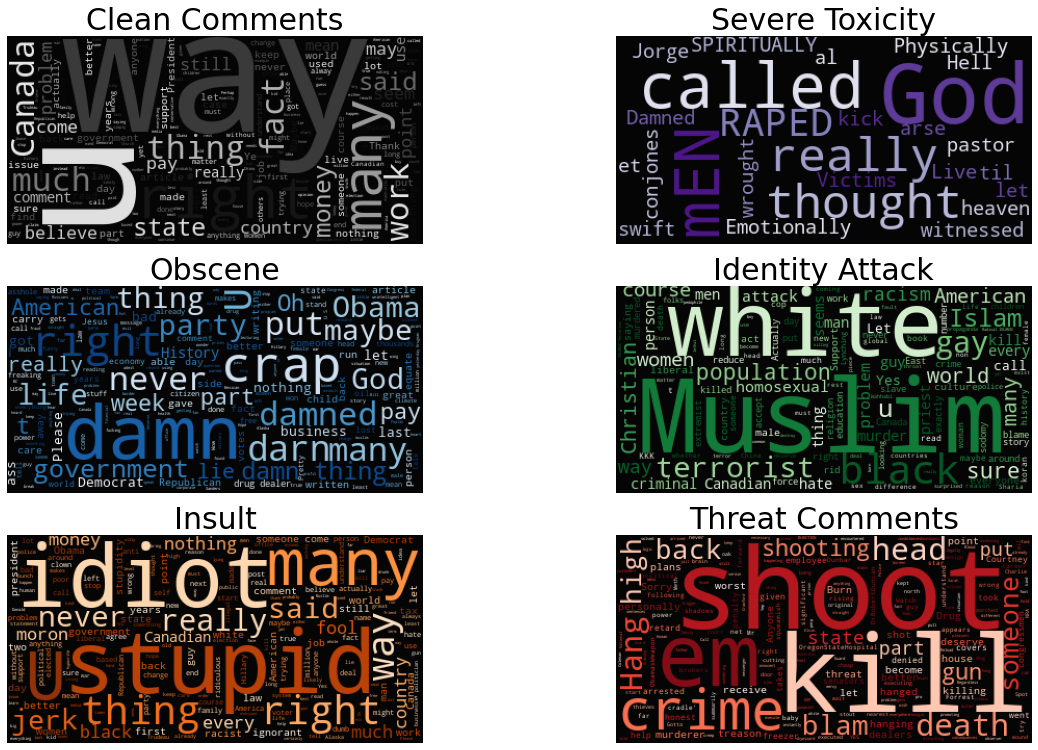

In [192]:
plt.figure(figsize=(20,13))
def plot(position,targets,threshold,use_equal,title,colormap):
    """
    Cloud of words plots.
    
    The function creates a 3x2 plot, showing the main words in each subtarget, 
    using acceptable thresholds. Clean or Zero rows we differ with == operands,
    all other subtargets go as >= operand.
    
    Parameters
    ----------
    position: subplot postion
    targets: chose exact subtarget column
    threshold: thresholds based on previous cut & qcut plots analysis
    use_equal: switch == to >=
    title: choses a title
    colormap: choses colormap
    
    Returns
    -------
    WordClouds plots.
    
    """
    plt.subplot(position)
    if use_equal:
        subset=df[df[targets]==threshold]
    else:
        subset=df[df[targets]>=threshold]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=200,stopwords=STOPWORDS.union(set(
        ['people','Trump','vote','need','enough','know','year','say','will','time','now','think','even','one','make',
         'word','want','good','take','give','love','well','go','look','hand','see','another','going'])))
    wc.generate(" ".join(text))
    plt.axis("off")
    plt.title(title, fontsize=30)
    plt.imshow(wc.recolor(colormap= colormap , random_state=111), alpha=0.98)
position=[321,322,323,324,325,326]
targets=['target','severe_toxicity','obscene','identity_attack','insult','threat']
threshold=[0,.6,.9,.9,.9,.9]
use_equal=[False,True,True,True,True,True]
title=["Clean Comments","Severe Toxicity","Obscene","Identity Attack","Insult","Threat Comments"]
colormap=['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
for i in range(6):
    plot(position[i],targets[i],threshold[i],use_equal[i],title[i],colormap[i])

* головне додати висновок: що ми знайшли, топ 5 слів з кожного субтаргету

In [450]:
#  сміттячко  
df.loc[:, "interval_target"] = (pd.qcut(df['target'], 20, duplicates='drop')).map(str)
df.groupby("interval_target")['id'].count()
df.loc[:,'interval_target']=(pd.qcut[df['target'],20,duplicates='drop']).map(str)
# df.groupby('interval_target')['id'].count()
df.iloc[:,3:8].apply(lambda x: , axis=0)
df.loc[:, "n_tag"] = 1
df.groupby([])["n_tag"].cumsum()       
rowsums[0:10][rowsums.sum(axis=1)!= 0].replace(0,np.nan).apply(lambda x: list(x.sort_values(ascending=False).index), 1 )

interval_target
(-0.001, 0.167]    1426138
(0.167, 0.2]        108542
(0.2, 0.4]          118731
(0.4, 0.6]           79228
(0.6, 1.0]           72235
Name: id, dtype: int64